In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlp import MLP
from sklearn.metrics import f1_score

In [13]:
def visualise_real_vs_predict(X_test, original_cat_test, pred):
    plt.figure()
    scatter_or = plt.scatter(X_test[:,0], X_test[:,1], c=pd.Categorical(original_cat_test).codes, cmap='viridis')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Original Categories')
    categories = pd.Categorical(original_cat_test).categories
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_or.cmap(scatter_or.norm(i)), markersize=10) for i in range(len(categories))]
    plt.legend(handles, categories, title='Categories')

    plt.figure()
    scatter_pr = plt.scatter(X_test[:,0], X_test[:,1], c=pd.Categorical(pred).codes, cmap='viridis')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Predicted Categories')
    categories = pd.Categorical(pred).categories
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_pr.cmap(scatter_pr.norm(i)), markersize=10) for i in range(len(categories))]
    plt.legend(handles, categories, title='Predicted Categories')
    plt.show()

In [14]:
def learn_with_val_vis(data, network, f_measure_target, metric, lr, info_interval = 100, momentum_coef = 0.0, batch_size = None, max_epochs=10**10):
    X_train, Y_train, X_test, Y_test = data
    k = 1/1000
    ef_lr = lr
    max_x = np.max(X_train, axis=0)
    min_x = np.min(X_train, axis=0)
    original_cat_test = np.argmax(Y_test, axis=1)

    avgx = (max_x + min_x) / 2


    x_scl = (max_x - min_x) / 2
    X_tr_scl = (X_train - avgx) / x_scl
    X_ts_scl = (X_test - avgx) / x_scl

    epoch = 0
    pred = network.predict_multiple(X_ts_scl)
    LOSS = cross_entropy_loss(Y_test, pred) if metric == "CE" else np.mean((Y_test-pred)**2)
    pred = np.argmax(pred, axis=1)
    f_measure = f1_score(original_cat_test, pred, average = 'macro')
    while(True):
        if epoch % info_interval == 0:
            print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, f-measure: {f_measure}")
        pred = network.predict_multiple(X_ts_scl)
        LOSS = cross_entropy_loss(Y_test, pred) if metric == "CE" else np.mean((Y_test-pred)**2)
        pred = np.argmax(pred, axis=1)
        f_measure = f1_score(original_cat_test, pred, average='macro')
        if f_measure >= f_measure_target or epoch > max_epochs:
            if epoch % info_interval != 0:
                print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, f-measure: {f_measure}")
            break
        network.epoch(X_tr_scl, Y_train, metric, ef_lr, momentum_coef, batch_size)
        epoch +=1
        ef_lr = lr / (1 + epoch *k)
    visualise_real_vs_predict(X_test, original_cat_test, pred)
    # plt.plot(X_test, Y_test, 'o', label='Original Data')
    # plt.plot(X_test, pred.reshape(-1), 'o', color='red', label='Predicted Data')
    # plt.xlabel("X-axis")
    # plt.ylabel("Y-axis")
    # plt.title(f"LOSS: {LOSS}")
    # plt.legend()

In [23]:
def rms_learn_with_val_vis(data, network, f_measure_target, metric, lr, info_interval = 100, rms_coef = 0.9, batch_size = None, max_epochs=10**10):
    X_train, Y_train, X_test, Y_test = data
    k = 1/1000
    ef_lr = lr
    max_x = np.max(X_train, axis=0)
    min_x = np.min(X_train, axis=0)
    original_cat_test = np.argmax(Y_test, axis=1)

    avgx = (max_x + min_x) / 2


    x_scl = (max_x - min_x) / 2
    X_tr_scl = (X_train - avgx) / x_scl
    X_ts_scl = (X_test - avgx) / x_scl

    epoch = 0
    pred = network.predict_multiple(X_ts_scl)
    LOSS = cross_entropy_loss(Y_test, pred) if metric == "CE" else np.mean((Y_test-pred)**2)
    pred = np.argmax(pred, axis=1)
    f_measure = f1_score(original_cat_test, pred, average = 'macro')
    while(True):
        if epoch % info_interval == 0:
            print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, f-measure: {f_measure}")
        pred = network.predict_multiple(X_ts_scl)
        LOSS = cross_entropy_loss(Y_test, pred) if metric == "CE" else np.mean((Y_test-pred)**2)
        pred = np.argmax(pred, axis=1)
        f_measure = f1_score(original_cat_test, pred, average='macro')
        if f_measure >= f_measure_target or epoch > max_epochs:
            if epoch % info_interval != 0:
                print(f"Weights, epoch: {epoch}, LOSS: {LOSS}, f-measure: {f_measure}")
            break
        network.rms_epoch(X_tr_scl, Y_train, metric, ef_lr, rms_coef, batch_size)
        epoch +=1
        ef_lr = lr / (1 + epoch *k)
    visualise_real_vs_predict(X_test, original_cat_test, pred)

In [15]:
def cross_entropy_loss(y_true, y_pred, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)  # Avoid log(0)
    return -np.sum(y_true * np.log(y_pred))

def one_hot_encode_last_column(df):
    column = df.columns[-1]  # Get the last column name
    one_hot = pd.get_dummies(df[column], prefix=column, dtype=int)  # One-hot encode
    df = df.drop(columns=[column])  # Drop original column
    return pd.concat([df, one_hot], axis=1)



# 1.1 XOR CE

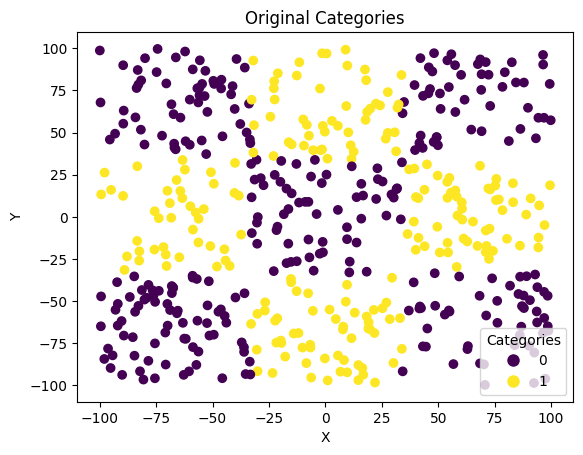

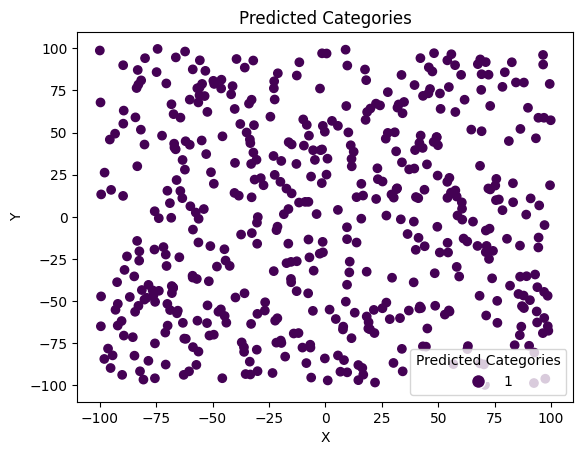

In [21]:
network = MLP([2,16,16,2], ["sigmoid", "sigmoid", "softmax"])
train = pd.read_csv("data/classification/xor3-training.csv")
original_cat_train = train['c'].values
train = one_hot_encode_last_column(train)
test = pd.read_csv("data/classification/xor3-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)


X_train = train[['x', 'y']].values
Y_train = train.drop(columns = ['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns = ['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)


avgx = (max_x + min_x) / 2


x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)
LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 1027.9015119274216, f-measure: 0.3702770780856423
Weights, epoch: 10, LOSS: 355.20839522312025, f-measure: 0.37639807528283364
Weights, epoch: 20, LOSS: 345.5044200296168, f-measure: 0.41196236559139787
Weights, epoch: 30, LOSS: 346.19157592007554, f-measure: 0.4670886893611524
Weights, epoch: 40, LOSS: 346.6070131114719, f-measure: 0.48051948051948046
Weights, epoch: 50, LOSS: 339.7775022763245, f-measure: 0.5012798481006573
Weights, epoch: 60, LOSS: 343.3508806496335, f-measure: 0.5057144234942373
Weights, epoch: 70, LOSS: 337.7120851908419, f-measure: 0.5188915260760794
Weights, epoch: 80, LOSS: 335.4111916548596, f-measure: 0.5488721804511278
Weights, epoch: 90, LOSS: 336.720800972348, f-measure: 0.5579840874271473
Weights, epoch: 100, LOSS: 340.98449048621774, f-measure: 0.5813204508856682
Weights, epoch: 110, LOSS: 332.3796582354172, f-measure: 0.5884178783242785
Weights, epoch: 120, LOSS: 328.1197635011953, f-measure: 0.6083909308184225
Weights, epoch: 1

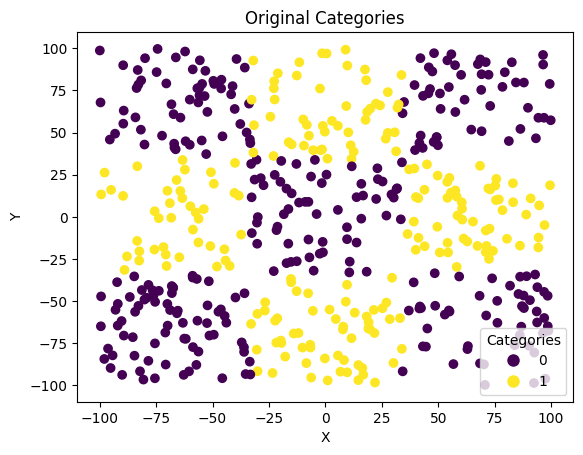

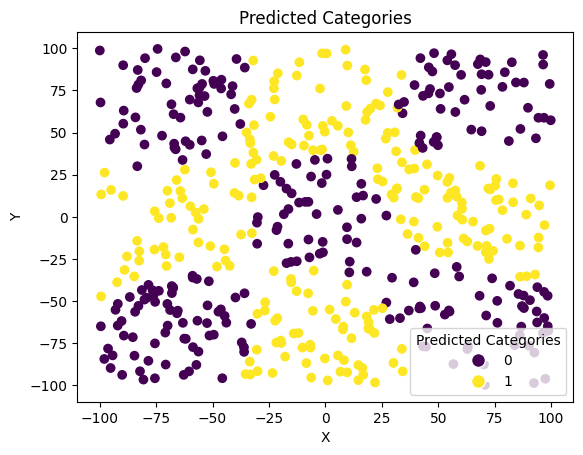

In [68]:
learn_with_val_vis(data, network, 0.97, "CE", 0.1, 10, 0.9, 32, 1000)

Weights, epoch: 0, LOSS: 1888.811734005185, f-measure: 0.29178470254957506
Weights, epoch: 10, LOSS: 344.3935636566598, f-measure: 0.46802270309194105
Weights, epoch: 20, LOSS: 328.4483771170949, f-measure: 0.619570745600651
Weights, epoch: 30, LOSS: 360.60606619250444, f-measure: 0.5648604269293924
Weights, epoch: 40, LOSS: 319.39967842731505, f-measure: 0.623932453416149
Weights, epoch: 50, LOSS: 284.26509270342456, f-measure: 0.7935631796882203
Weights, epoch: 60, LOSS: 254.40775422403834, f-measure: 0.7639139436057
Weights, epoch: 70, LOSS: 222.0540633692313, f-measure: 0.6829316434219865
Weights, epoch: 80, LOSS: 206.52507449582788, f-measure: 0.8078893442622951
Weights, epoch: 90, LOSS: 142.32658110106414, f-measure: 0.8818140323422013
Weights, epoch: 100, LOSS: 159.64200785395656, f-measure: 0.8654137422612902
Weights, epoch: 110, LOSS: 112.74871589988794, f-measure: 0.9136782913234351
Weights, epoch: 120, LOSS: 113.65667659468075, f-measure: 0.8889126434179693
Weights, epoch: 1

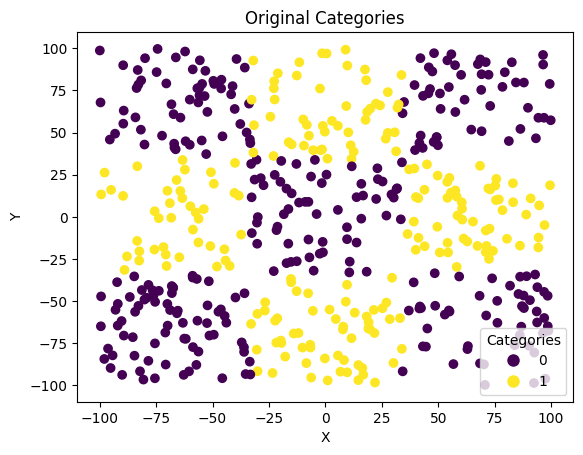

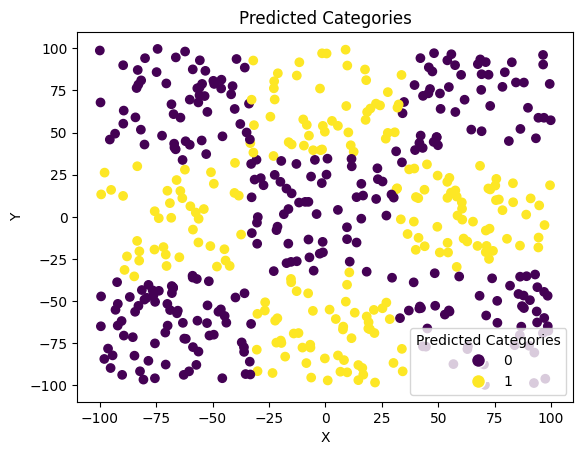

In [24]:
rms_learn_with_val_vis(data, network, 0.97, "CE", 0.1, 10, 0.9, 32, 1000)

# 1.2 XOR MSE

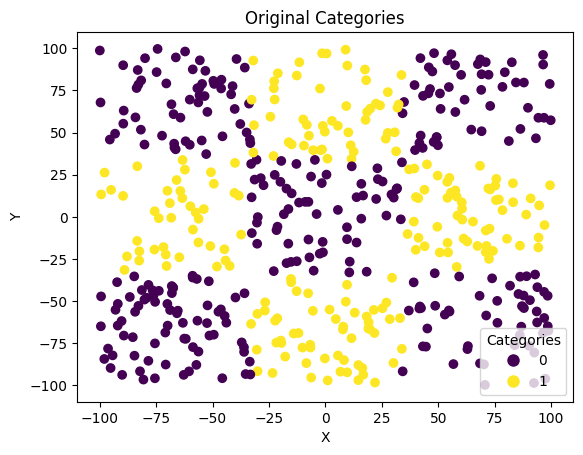

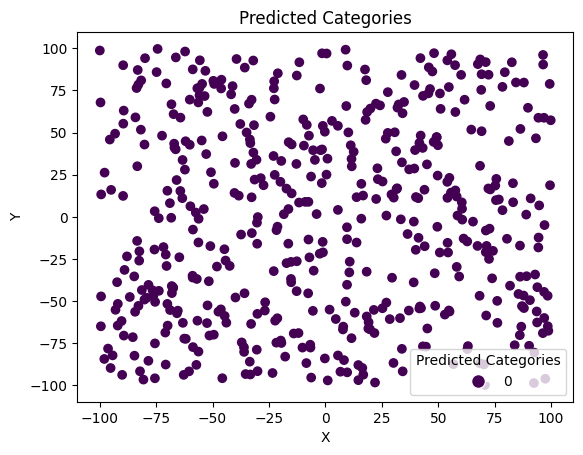

In [28]:
network = MLP([2,16,16,2], ["sigmoid", "sigmoid", "softmax"])
train = pd.read_csv("data/classification/xor3-training.csv")
original_cat_train = train['c'].values
train = one_hot_encode_last_column(train)
test = pd.read_csv("data/classification/xor3-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)


X_train = train[['x', 'y']].values
Y_train = train.drop(columns = ['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns = ['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)


avgx = (max_x + min_x) / 2


x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)
LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 0.03552567942442178, f-measure: 0.9571356839307803
Weights, epoch: 10, LOSS: 0.03555845262996551, f-measure: 0.9490293142607824
Weights, epoch: 20, LOSS: 0.03410334885186031, f-measure: 0.9591042188087877
Weights, epoch: 30, LOSS: 0.03397901221563366, f-measure: 0.9570332480818414
Weights, epoch: 40, LOSS: 0.03592054149876768, f-measure: 0.9510954616588418
Weights, epoch: 50, LOSS: 0.03382021159528065, f-measure: 0.9570332480818414
Weights, epoch: 60, LOSS: 0.033788316136795914, f-measure: 0.9570332480818414
Weights, epoch: 70, LOSS: 0.0354528920554368, f-measure: 0.9510954616588418
Weights, epoch: 80, LOSS: 0.03472636547425354, f-measure: 0.9550682961897916
Weights, epoch: 90, LOSS: 0.03504083635045287, f-measure: 0.9530533681146641
Weights, epoch: 100, LOSS: 0.034719636324543744, f-measure: 0.9530533681146641
Weights, epoch: 110, LOSS: 0.03486428244526351, f-measure: 0.9571356839307803
Weights, epoch: 120, LOSS: 0.034126799826997956, f-measure: 0.957085228735

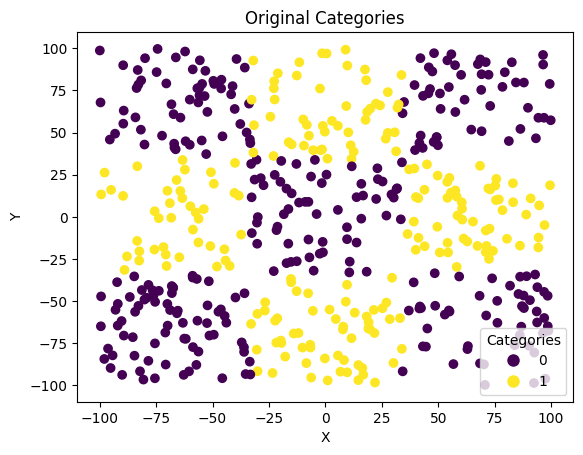

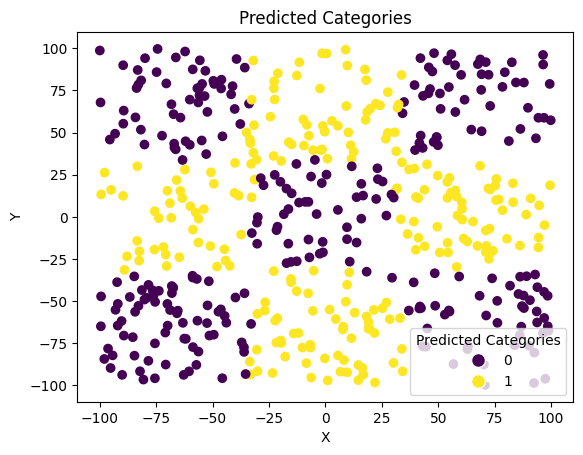

In [10]:
learn_with_val_vis(data, network, 0.97, "MSE", 0.02, 10, 0.9, 10, 500)

Weights, epoch: 0, LOSS: 0.35047046575281565, f-measure: 0.3702770780856423
Weights, epoch: 10, LOSS: 0.24215535395041887, f-measure: 0.3702770780856423
Weights, epoch: 20, LOSS: 0.2548284890566158, f-measure: 0.5864452306079665
Weights, epoch: 30, LOSS: 0.22673225061716637, f-measure: 0.677938808373591
Weights, epoch: 40, LOSS: 0.19370569772149862, f-measure: 0.5895504370080641
Weights, epoch: 50, LOSS: 0.1593559613504924, f-measure: 0.8019358272080155
Weights, epoch: 60, LOSS: 0.14644289364583316, f-measure: 0.8139933037589353
Weights, epoch: 70, LOSS: 0.1113591112198934, f-measure: 0.8352381411647458
Weights, epoch: 80, LOSS: 0.09222259916841005, f-measure: 0.8743529175252551
Weights, epoch: 90, LOSS: 0.05726183474392923, f-measure: 0.9382573761854585
Weights, epoch: 100, LOSS: 0.06909096383516336, f-measure: 0.8956874199028403
Weights, epoch: 110, LOSS: 0.049291299905612124, f-measure: 0.9284753812262181
Weights, epoch: 120, LOSS: 0.07796468042711402, f-measure: 0.8861344264428395


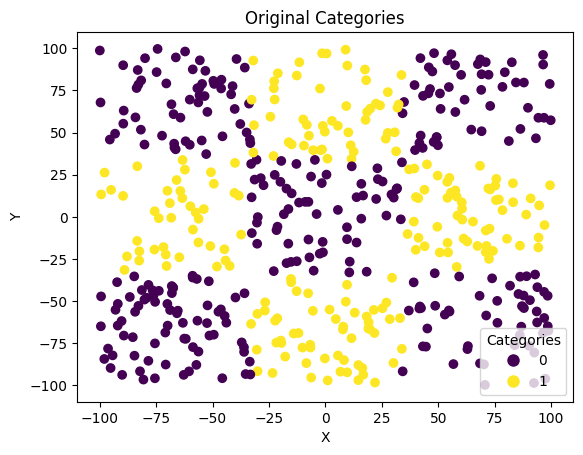

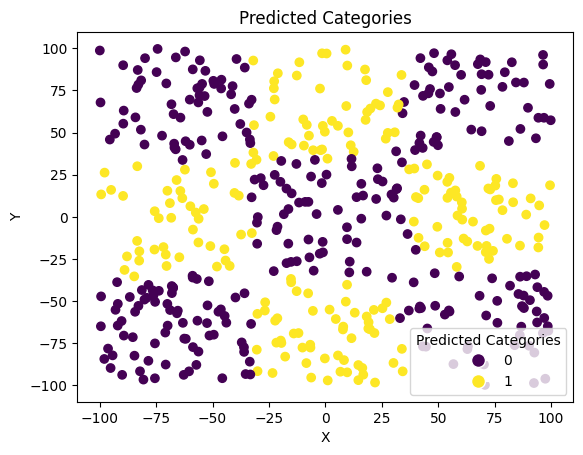

In [29]:
rms_learn_with_val_vis(data, network, 0.97, "MSE", 0.3, 10, 0.9, 32, 1000)

# 2.1 EASY CE

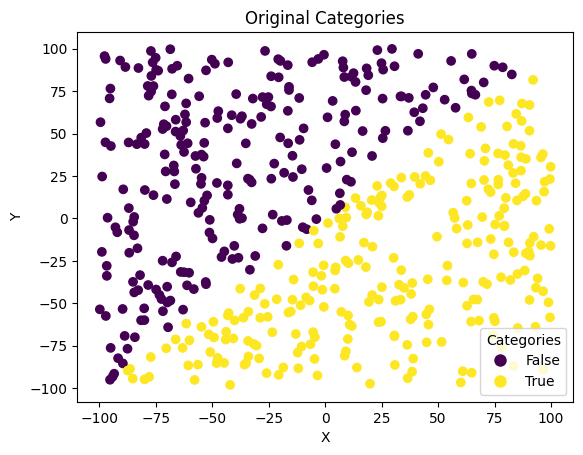

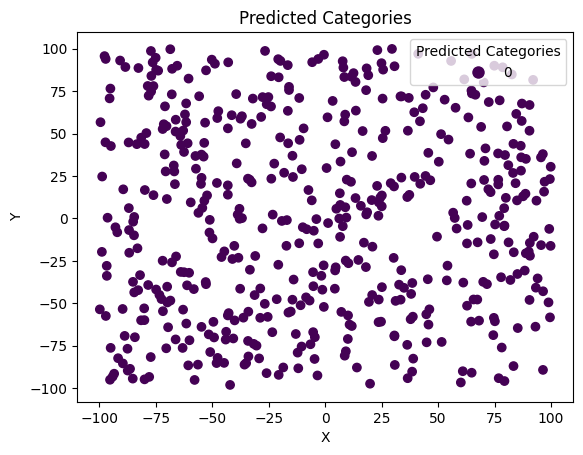

In [55]:
network = MLP([2,16,16,2], ["sigmoid", "sigmoid", "softmax"])
train = pd.read_csv("data/classification/easy-training.csv")
original_cat_train = train['c'].values
train = one_hot_encode_last_column(train)
test = pd.read_csv("data/classification/easy-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)


X_train = train[['x', 'y']].values
Y_train = train.drop(columns = ['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns = ['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)


avgx = (max_x + min_x) / 2

x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)
LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 1024.3696075075059, f-measure: 0.6702127659574468
Weights, epoch: 10, LOSS: 127.11959665414787, f-measure: 0.9673469387755103
Weights, epoch: 20, LOSS: 78.77301167348739, f-measure: 0.9757085020242915
Weights, epoch: 21, LOSS: 72.14271350117625, f-measure: 0.9920318725099602


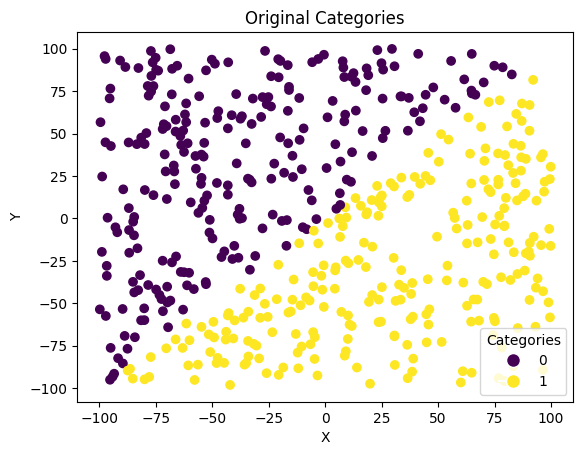

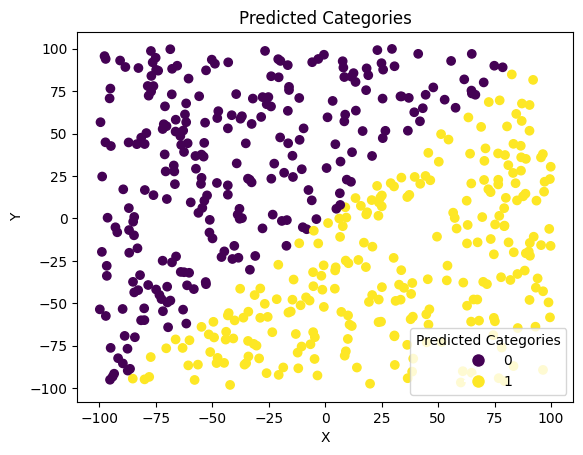

In [34]:
learn_with_val_vis(data, network, 0.99, "CE", 0.1, 10, 0.9, 32, 1000)

# 2.2 EASY MSE

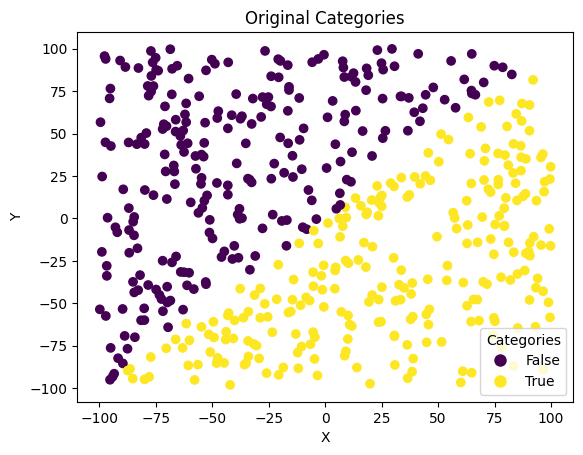

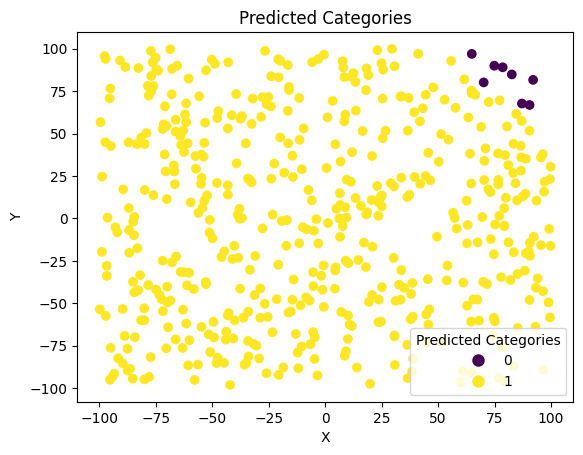

In [16]:
network = MLP([2,16,16,2], ["sigmoid", "sigmoid", "softmax"])
train = pd.read_csv("data/classification/easy-training.csv")
original_cat_train = train['c'].values
train = one_hot_encode_last_column(train)
test = pd.read_csv("data/classification/easy-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)


X_train = train[['x', 'y']].values
Y_train = train.drop(columns = ['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns = ['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)


avgx = (max_x + min_x) / 2

x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)
LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 0.3188380327215971, f-measure: 0.3542086693548387
Weights, epoch: 10, LOSS: 0.062487724786256325, f-measure: 0.977999207971487
Weights, epoch: 20, LOSS: 0.042786699456341545, f-measure: 0.9839989759344598
Weights, epoch: 30, LOSS: 0.03323623782765683, f-measure: 0.985999943999776
Weights, epoch: 40, LOSS: 0.028502923183441952, f-measure: 0.985999943999776
Weights, epoch: 50, LOSS: 0.026718578422519484, f-measure: 0.9859994959818554
Weights, epoch: 60, LOSS: 0.02354123487123859, f-measure: 0.9899999599998399
Weights, epoch: 61, LOSS: 0.02272943998278952, f-measure: 0.992


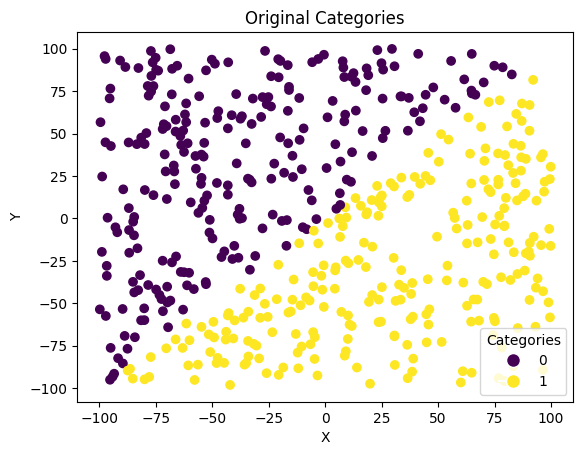

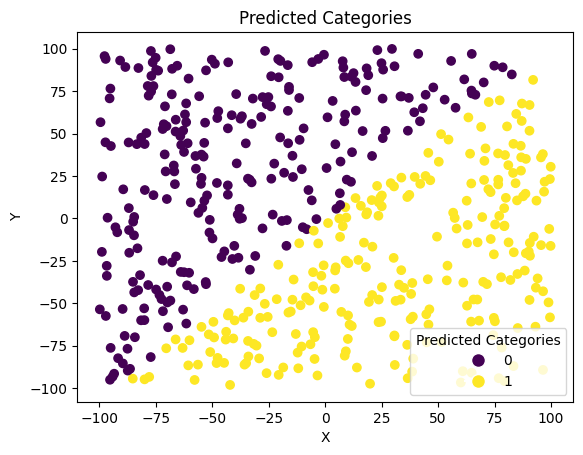

In [17]:
learn_with_val_vis(data, network, 0.99, "MSE", 0.1, 10, 0.9, 32, 1000)

# 3.1 RINGS3 CE

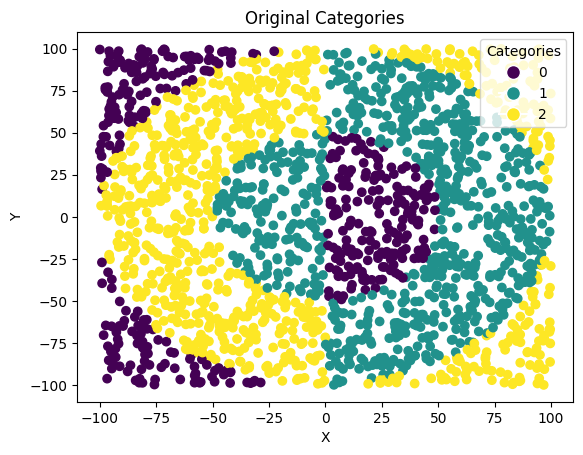

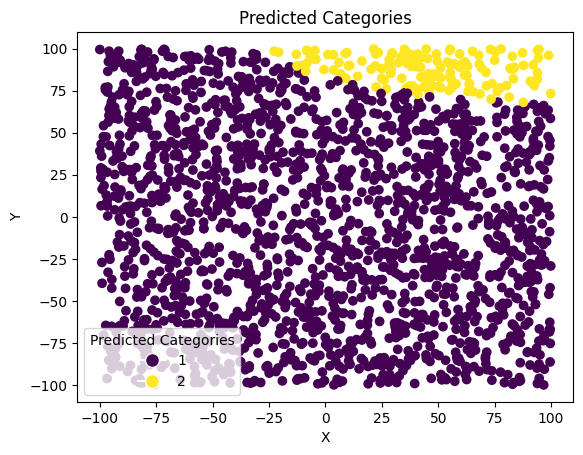

In [57]:
network = MLP([2,16,16,3], ["sigmoid", "sigmoid", "softmax"])
train = pd.read_csv("data/classification/rings3-regular-training.csv")
train = one_hot_encode_last_column(train)
test = pd.read_csv("data/classification/rings3-regular-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)



X_train = train[['x', 'y']].values
Y_train = train.drop(columns = ['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns = ['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)


avgx = (max_x + min_x) / 2


x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)

LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 1131.4120947064791, f-measure: 0.8075707586402814
Weights, epoch: 10, LOSS: 1039.1782123500197, f-measure: 0.8473156147947997
Weights, epoch: 20, LOSS: 934.745506509033, f-measure: 0.8761304676589541
Weights, epoch: 30, LOSS: 857.2360617619115, f-measure: 0.8811542372447435
Weights, epoch: 40, LOSS: 802.7338010966898, f-measure: 0.8894411955815466
Weights, epoch: 50, LOSS: 766.6379212246428, f-measure: 0.8899537429908388
Weights, epoch: 60, LOSS: 703.4243003497581, f-measure: 0.8889691537208114
Weights, epoch: 70, LOSS: 670.8678509507149, f-measure: 0.9019069572027663
Weights, epoch: 80, LOSS: 638.1128318649112, f-measure: 0.8914568393948322
Weights, epoch: 90, LOSS: 606.067424472495, f-measure: 0.9054793089559235
Weights, epoch: 100, LOSS: 592.2501377378674, f-measure: 0.8953412199152512
Weights, epoch: 110, LOSS: 575.4510798312418, f-measure: 0.9048536555999434
Weights, epoch: 120, LOSS: 554.4935754184016, f-measure: 0.9042608690655211
Weights, epoch: 130, LO

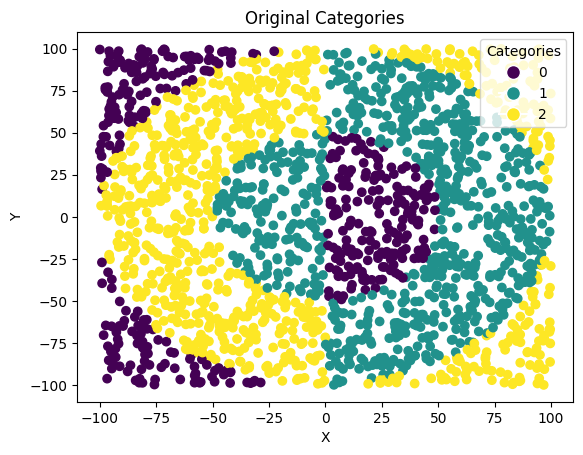

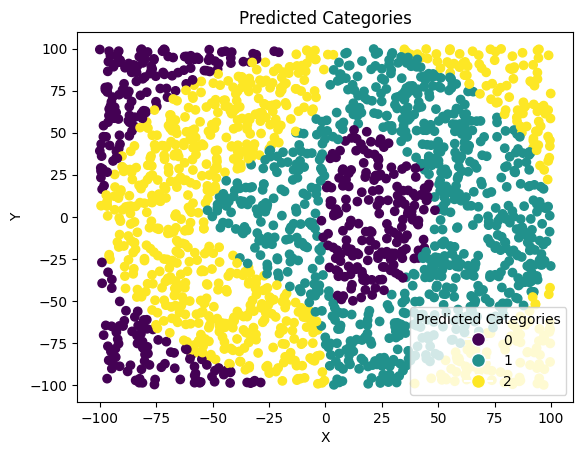

In [66]:
learn_with_val_vis(data, network, 0.99, "CE", 0.1, 10, 0.9, 32, 500)

# 3.2 RINGS3 MSE

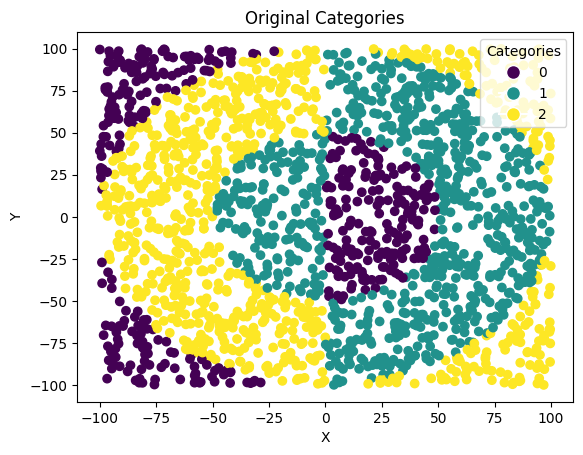

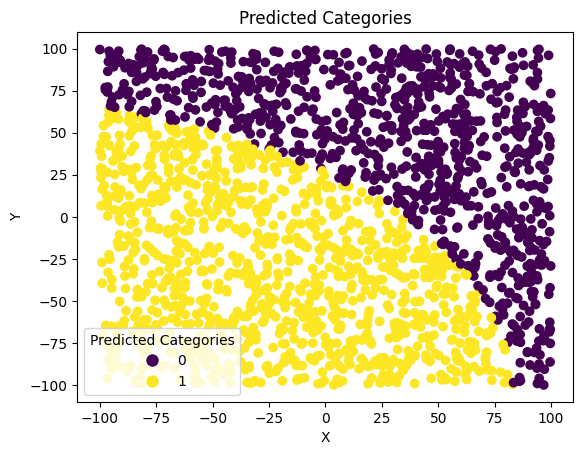

In [18]:
network = MLP([2,16,16,3], ["sigmoid", "sigmoid", "softmax"])
train = pd.read_csv("data/classification/rings3-regular-training.csv")
train = one_hot_encode_last_column(train)
test = pd.read_csv("data/classification/rings3-regular-test.csv")
original_cat_test = test['c'].values
test = one_hot_encode_last_column(test)



X_train = train[['x', 'y']].values
Y_train = train.drop(columns = ['x', 'y']).values
X_test = test[['x', 'y']].values
Y_test = test.drop(columns = ['x', 'y']).values

data = (X_train, Y_train, X_test, Y_test)

max_x = np.max(X_train, axis=0)
min_x = np.min(X_train, axis=0)


avgx = (max_x + min_x) / 2


x_scl = (max_x - min_x) / 2
X_tr_scl = (X_train - avgx) / x_scl
X_ts_scl = (X_test - avgx) / x_scl

pred = network.predict_multiple(X_ts_scl)

LOSS = cross_entropy_loss(Y_test, pred)
pred = np.argmax(pred, axis=1)
visualise_real_vs_predict(X_test, original_cat_test, pred)

Weights, epoch: 0, LOSS: 0.30358782777037596, f-measure: 0.21435820927055885
Weights, epoch: 10, LOSS: 0.19705654186789456, f-measure: 0.4124552953193514
Weights, epoch: 20, LOSS: 0.19176239067466566, f-measure: 0.4676264278693441
Weights, epoch: 30, LOSS: 0.19439237870357817, f-measure: 0.39306601104493405
Weights, epoch: 40, LOSS: 0.1865007707895212, f-measure: 0.4957552938990151
Weights, epoch: 50, LOSS: 0.18728337028785852, f-measure: 0.5429061032058882
Weights, epoch: 60, LOSS: 0.1844710257098781, f-measure: 0.548282696997774
Weights, epoch: 70, LOSS: 0.17635350629258964, f-measure: 0.5861045013882268
Weights, epoch: 80, LOSS: 0.1784574286046488, f-measure: 0.6008123211737028
Weights, epoch: 90, LOSS: 0.1736293653032141, f-measure: 0.5987319872223145
Weights, epoch: 100, LOSS: 0.17043418092313828, f-measure: 0.613587375426106
Weights, epoch: 110, LOSS: 0.16452810043688554, f-measure: 0.6158030187586482
Weights, epoch: 120, LOSS: 0.16200442100014104, f-measure: 0.6187333824968287
W

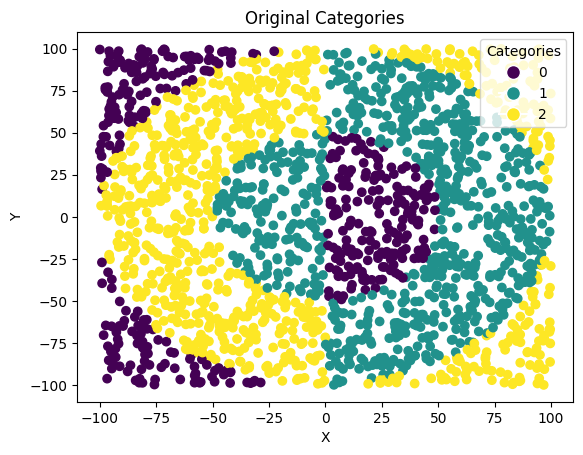

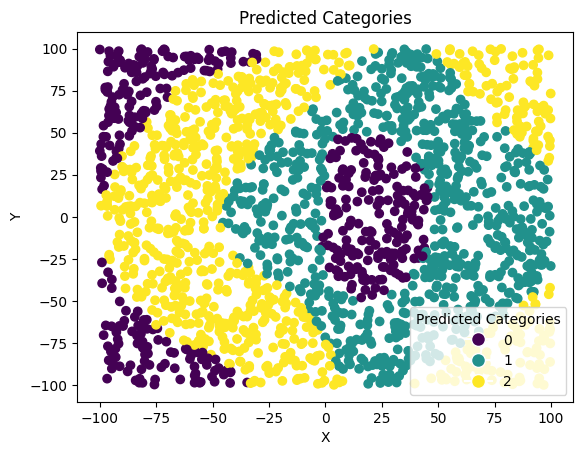

In [19]:
learn_with_val_vis(data, network, 0.99, "MSE", 0.1, 10, 0.9, 32, 500)